<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Diego Alberto López Lazareno,  Esteban Márquez Delgado.

**Fecha:** 14 de octubre del 2021.

**Expediente** : 722100, 700637.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
# Proyecto TEMA-2: Descarga de Datos

## Objetivo:

+ Descargar los datos fundamentales para las firmas financieras que forman parte del índice S&P $500$ con ayuda de la API de **Financial Modeling Prep**.

### Objetivos Específicos:

+ Descargar los datos fundamentales para los siguientes nodos: Margen de Beneficio Neto, Ratio Payout, Precio a Dividendos y Beta.
+ Filtrar los datos fundamentales con técnicas estadísticas.
+ Almacenar los datos fundamentales en un archivo de excel.


In [32]:
# Librerías necesarias
# Análisis y manejo de datos
import pandas as pd
import numpy as np

# Yfinance
import yfinance as yf
import seaborn as sns

# Visualización
import matplotlib.pyplot as plt
%matplotlib inline

# Librerías de estimación de densidad KDE
from sklearn.neighbors import KernelDensity 
from scipy.stats import gaussian_kde 
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy.stats.distributions import norm

#Librería de box-whisker plots.
import plotly.express as px

# Conexión a la API de Financial Modeling Prep
#from pyfmpcloud import settings
#from pyfmpcloud import company_valuation as cv
#api_key = pd.read_csv("Data/apiKey_FMP.csv").iloc[0, 0]
#settings.set_apikey(api_key)

# Filtrado de alertas
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Se obtienen las compañías listadas en el índice S&P 500 que pertenecen al sector financiero
sp500_companies = pd.DataFrame(pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0])
financialSector = sp500_companies[sp500_companies["GICS Sector"] == "Financials"]
# Símbolos de cotización
tickers = list(financialSector["Symbol"])

# Compañías financieras clasificadas por sub-industria
financialSector = pd.DataFrame(financialSector.groupby(["GICS Sub-Industry"])["GICS Sub-Industry"].count())
financialSector.loc["Total"] = financialSector.values.sum()
financialSector

,GICS Sub-Industry
GICS Sub-Industry,
Asset Management & Custody Banks,8
Consumer Finance,4
Diversified Banks,6
Financial Exchanges & Data,8
Insurance Brokers,5
Investment Banking & Brokerage,4
Life & Health Insurance,5
Multi-Sector Holdings,1
Multi-line Insurance,3


+ Existe un total de $65$ empresas del sector financiero que forman parte del índice S&P $500$.

In [3]:
## ------------------------------------------------ Configuraciones iniciales  --------------------------------------------- ##

# Función que calcula el margen de beneficio neto
f_netProfitMargin = lambda df : list(df["netIncome"] / df["revenue"])

# Función que calcula el ratio payout
f_ratioPayout = lambda df : list(abs(df["dividendsPaid"]) / df["netIncome"])

# Cálculo de Beta
def f_beta(ticker : "Símbolo de cotización", start : "Fecha de inicio", end : "Fecha final"):
    """
    f_beta devuelve la medida de volatilidad entre una acción relativa a al índice S&P 500, es decir, la Beta.
    
    ticker : Es el símbolo de cotización de una acción.
    start : Fecha de inicio para la descarga de precios históricos.
    end : Fecha de fin para la descarga de precios históricos.
    
    """
    # Descarga de precios históricos
    prices = pd.DataFrame()
    prices[ticker] = yf.download(ticker, start = start, end = end,  progress = False)["Adj Close"]
    prices["^GSPC"] = yf.download("^GSPC", start = start, end = end,  progress = False)["Adj Close"]
    
    # Cálculo de Beta
    CovMatrix = prices.dropna().pct_change().dropna().cov()
    beta = CovMatrix.iloc[0, 1] / CovMatrix.iloc[1, 1]
        
    return beta

def histogram(x : "Variable aleatoria", density = True, bins = 50, label = "Etiqueta", color = "Color"):
    """
    histogram devuelve el histograma de la variable aleatoria x.
    
    x: Variable aleatoria.
    density : Es la densidad de la distribución de probabilidad.
    bins : Es el número de categorías para el graficado del histograma, por defecto se establece en 50.
    label : Es el etiquetado para la visualización.
    color : Color del histograma.
    
    """
    plt.figure(figsize = (10, 5))
    plt.hist(x, bins = bins, density = density, label = label, color = color)
    plt.legend();
    
    
def filterByQuantiles(data : "Datos a filtrar", alpha = 0.05):
    """
    filterByQuantiles filtra una serie de datos, eliminando los valores que se encuentran en las colas de la distribución.
    
    data : Son los datos a filtrar.
    alpha: Es el nivel de significancia, por defecto se establece en 5%.
    
    """
    quantiles = np.quantile(data, [alpha, (1 - alpha)])
    filteredData = data[(data >= quantiles[0]) & (data <= quantiles[1])]
    
    return filteredData
    

## Nodos

In [4]:
#Lectura de datos en excel por falta de api_key del colaborador (1 por proyecto $..)
data_MargenNeto = pd.read_excel("Data/MargenNeto.xlsx", sheet_name = "Nodo1")
data_RatioPayout = pd.read_excel("Data/RatioPayout.xlsx", sheet_name = "Nodo2")
data_PrecioDividendos = pd.read_excel("Data/PrecioDividendos.xlsx", sheet_name = "Nodo3")
data_Betas = pd.read_excel("Data/Betas.xlsx", sheet_name = "Nodo4")

### 1. Margen de Beneficio Neto

In [5]:
# Descarga de datos para la simulación del primer nodo
#netProfitMargins = np.concatenate(list(map(lambda ticker : 
                                           #f_netProfitMargin(cv.income_statement(ticker)[["revenue", "netIncome"]]), tickers)))

# Filtrado de datos
#netProfitMargins = netProfitMargins[(netProfitMargins != float("inf")) & (netProfitMargins != float("-inf"))]
#netProfitMargins = filterByQuantiles(netProfitMargins)

# Quitar 1° índice (Sólo una vez)
data_MargenNeto = data_MargenNeto.drop(data_MargenNeto.columns[[0]], axis=1)

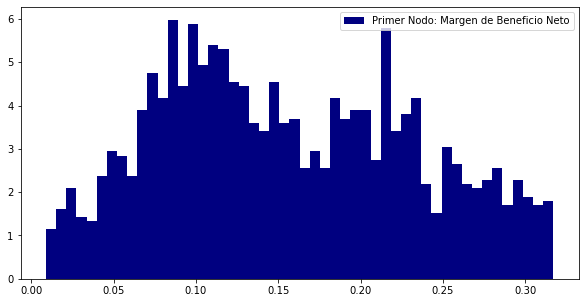

In [6]:
# Visualización
histogram(data_MargenNeto, bins = 50, label = "Primer Nodo: Margen de Beneficio Neto", color = "navy")

### 2. Ratio Payout

In [7]:
# Descarga de datos para la simulación del segundo nodo
#payoutRatios = np.concatenate(list(map(lambda ticker : 
                                       #f_ratioPayout(cv.cash_flow_statement(ticker)[["netIncome", "dividendsPaid"]]), tickers)))

# Filtrado de datos
#payoutRatios = payoutRatios[(payoutRatios != float("inf")) & (payoutRatios != float("-inf")) & (payoutRatios > 0)]
#payoutRatios = filterByQuantiles(payoutRatios)

# Quitar 1° índice (Sólo una vez)
data_RatioPayout = data_RatioPayout.drop(data_RatioPayout.columns[[0]], axis=1)

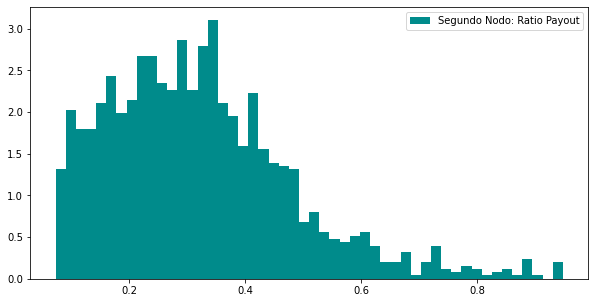

In [8]:
# Visualización
histogram(data_RatioPayout, bins = 50, label = "Segundo Nodo: Ratio Payout", color = "darkcyan")

### 3. Precio a Dividendos

In [9]:
# Descarga de datos para la simulación del tercer nodo
#priceToDividends = np.concatenate(list(map(lambda ticker : list(1 / cv.key_metrics(ticker)["dividendYield"]), tickers)))

# Filtrado de datos
#priceToDividends = priceToDividends[(priceToDividends > 0)]
#priceToDividends = filterByQuantiles(priceToDividends)

# Quitar 1° índice (Sólo una vez)
data_PrecioDividendos = data_PrecioDividendos.drop(data_PrecioDividendos.columns[[0]], axis=1)

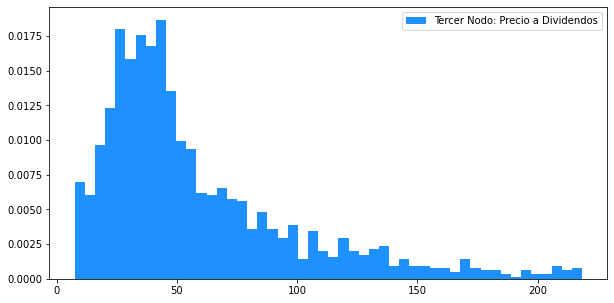

In [10]:
# Visualización
histogram(data_PrecioDividendos, bins = 50, label = "Tercer Nodo: Precio a Dividendos", color = "dodgerblue")

### 4. Beta

In [11]:
# Descarga de datos para la simulación del cuarto nodo
#dates = [(str(i) + "-01-01", str(i) + "-12-31") for i in range(2010, 2021)]
#betas = list(map(lambda date : list(map(lambda ticker : f_beta(ticker, date[0], date[1]), tickers)), dates))

# Filtrado de datos
#betasDF = pd.DataFrame(np.concatenate(betas)).dropna()
#betasFinancialSector = list(map(lambda i : float(betasDF.iloc[i]), range(len(betasDF))))
#betasFinancialSector = filterByQuantiles(np.array(betasFinancialSector))
# Quitar 1° índice (Sólo una vez)
data_Betas = data_Betas.drop(data_Betas.columns[[0]], axis=1)

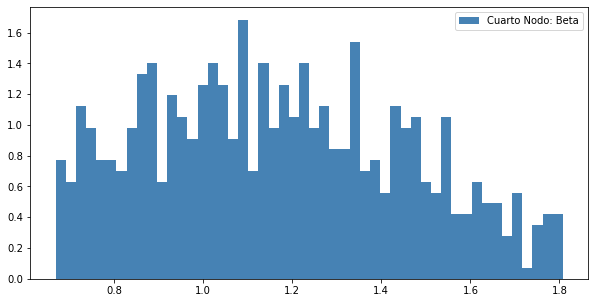

In [12]:
histogram(data_Betas, bins = 50, label = "Cuarto Nodo: Beta", color = "steelblue")

In [13]:
# Almacenamiento de información en excel
#pd.DataFrame(netProfitMargins).to_excel("Data/MargenNeto.xlsx", sheet_name = "Nodo1")
#pd.DataFrame(payoutRatios).to_excel("Data/RatioPayout.xlsx", sheet_name = "Nodo2")
#pd.DataFrame(priceToDividends).to_excel("Data/PrecioDividendos.xlsx", sheet_name = "Nodo3")
#pd.DataFrame(betasFinancialSector).to_excel("Data/Betas.xlsx", sheet_name = "Nodo4")

In [26]:
#Box-Whisker Plots
#Install w/ Anaconda Prompt: conda install -c plotly plotly_express & Customize w/ documentation 
import plotly.express as px
df = px.data.tips()
bw_betas = px.box(data_Betas, points="all", width=750, height=300, template= "plotly_dark",
            title="Box-Whisker Plot of Betas", orientation="h")
bw_PrecioDividendos = px.box(data_PrecioDividendos, points="all", width=830, height=350,
            template= "plotly",title="Box-Whisker of Plot Price Dividends", orientation="h")
bw_RatioPayout = px.box(data_RatioPayout, points="all", width=750, height=300,
            template= "plotly_dark", title="Box-Whisker Plot of Ratio Payout", orientation="h")
bw_NetProfit = px.box(data_MargenNeto, points="all", width=830, height=350,
            template= "plotly",title="Box-Whisker of Net Profit Margin", orientation="h")

bw_betas.show(), bw_PrecioDividendos.show(), bw_RatioPayout.show(), bw_NetProfit.show()

(None, None, None, None)

In [31]:
def boxplot(data, size, color, title):
    """
    Grafica un diagrama de caja para representar los datos ingresados.

    *data : datos numéricos.
    *size : tamaño del gráfico, se debe de ingresar como una tupla de la forma (ancho, alto).
    *color : color del gráfico.
    *título : título del gráfico.

    """

    plt.figure(figsize = (size[0], size[1]))
    plt.title(title)
    sns.boxplot(x = data, color = color)

#### Posibles soluciones a la estimación de bandwidth:

In [35]:
#GridSearch hace una búsqueda exhaustiva para hacer mi CV y dependiendo de cuantas CV defina, los conjuntos
#de prueba que se realizan.
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(-4, 4, 20)},
                    cv=20) # 20-fold cross-validation
grid.fit(np.log(data_MargenNeto))
print(grid.best_params_)

{'bandwidth': 0.21052631578947345}


In [33]:
grid = GridSearchCV(KernelDensity(kernel = 'gaussian'),{'bandwidth': np.linspace(-4, 4, 20)}, cv = 5)
grid.fit(np.log(data_MargenNeto))
print(grid.best_params_)

{'bandwidth': 0.21052631578947345}


In [23]:
grid = GridSearchCV(KernelDensity(kernel = 'gaussian'),{'bandwidth': np.linspace(0.1, 0.5, 20)}, cv = 5)
grid.fit(np.log(data_PrecioDividendos))
print(grid.best_params_)

{'bandwidth': 0.1}


In [24]:
grid = GridSearchCV(KernelDensity(kernel = 'gaussian'),{'bandwidth': np.linspace(0.1, 0.5, 20)}, cv = 5)
grid.fit(np.log(data_RatioPayout))
print(grid.best_params_)

{'bandwidth': 0.1}


Text(0, 0.5, 'Densidad')

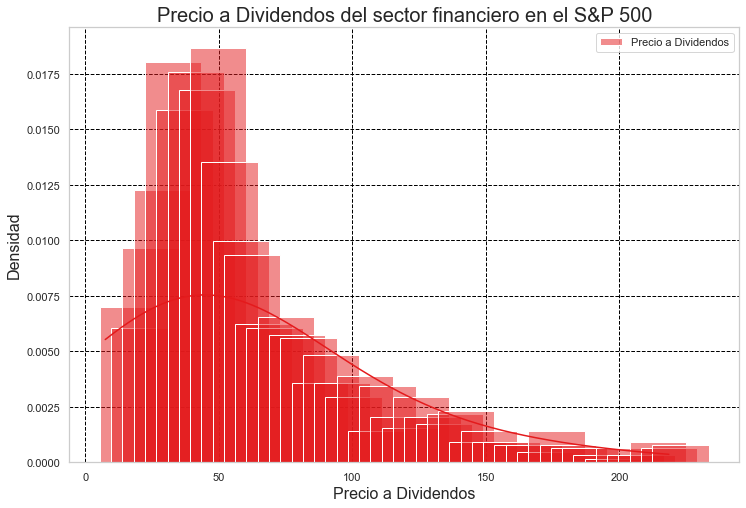

In [19]:
#https://www.sharpsightlabs.com/blog/seaborn-histogram/
#For visualizing univariate data distributions – seaborn.kdeplot() and seaborn.distplot().
#Estética seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid", {"grid.color": "black", "grid.linestyle": "--"})
sns.set_context(rc={"grid.linewidth": 1})
sns.set_palette("Set1", 1)

#Gráfico
sns.histplot(data=data_PrecioDividendos, stat='density', kde=True, kde_kws={'bw_method': 1},
             bins=50, log_scale=False, shrink=5)

#Estética matplot
plt.title('Precio a Dividendos del sector financiero en el S&P 500', fontsize=20)
plt.xlabel('Precio a Dividendos', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

In [20]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=2).fit(data_PrecioDividendos)
kde.score_samples(data_PrecioDividendos)

array([-4.02733328, -4.54705848, -4.15198864, ..., -4.35889175,
       -4.66510144, -4.93746805])

Text(0, 0.5, 'Densidad')

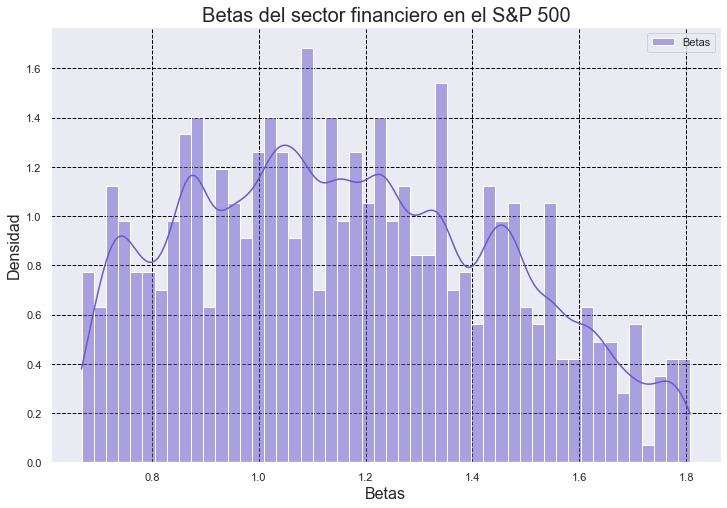

In [27]:
#Estética seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("darkgrid", {"grid.color": "black", "grid.linestyle": "--"})
sns.set_context(rc={"grid.linewidth": 1})
colors = ["#6959CD", "#4374B3"]
sns.set_palette(sns.color_palette(colors))

#Gráfico
sns.histplot(data=data_Betas, stat='density', kde=True, kde_kws={'bw_method': 0.1},
             bins=50, log_scale=False, shrink=1)

#Estética matplot
plt.title('Betas del sector financiero en el S&P 500', fontsize=20)
plt.xlabel('Betas', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

In [29]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=.1).fit(data_Betas)
kde.score_samples(data_Betas)

array([-9.43831499e-01,  1.39366533e-01, -1.48625468e-01, -3.99352057e-01,
       -3.23094663e-01, -2.25942919e-01, -5.05115516e-01,  1.36174797e-01,
       -4.68315463e-01,  1.43860992e-01,  1.48809268e-01, -7.44003519e-01,
       -1.87133395e-01,  1.44546770e-01, -2.15505051e-01,  1.29982958e-01,
       -1.74374298e-01,  1.38877265e-01,  4.72259589e-02, -3.53553418e-01,
       -4.16368766e-01, -1.48611119e+00,  8.00723534e-02, -1.80664587e-01,
        5.45505397e-03,  7.85841464e-02, -1.61925345e+00, -6.86435262e-01,
        7.19107521e-02, -1.33870457e+00, -2.71432216e-02, -4.23777791e-01,
        1.50893456e-01,  7.87700580e-02,  8.65526705e-02,  3.85059184e-02,
       -3.43888060e-01,  1.49942219e-01, -1.36631679e-02,  1.26906150e-01,
        1.06319711e-01,  1.51656425e-01, -4.59227608e-02, -1.58479178e+00,
        1.39882704e-01, -4.19668261e-01,  9.42815301e-02, -9.53883588e-01,
        1.08525376e-02, -7.46180722e-02, -2.80993891e-01, -2.73262827e-01,
       -4.99335883e-01,  

Text(0, 0.5, 'Densidad')

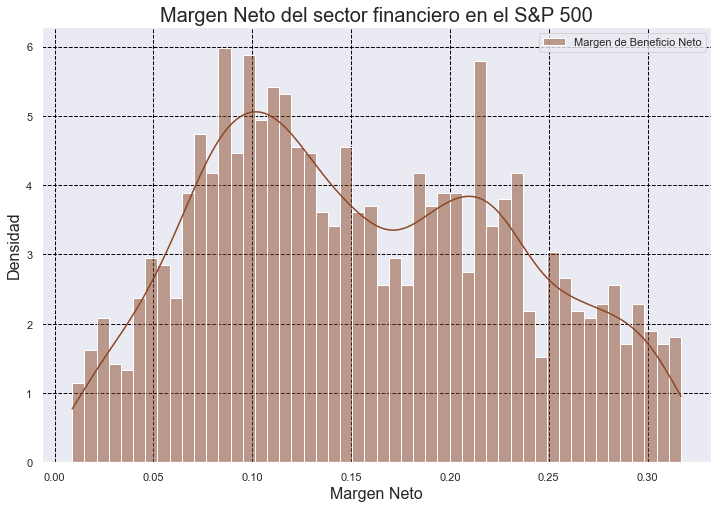

In [25]:
#Estética seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("darkgrid", {"grid.color": "black", "grid.linestyle": "--"})
sns.set_context(rc={"grid.linewidth": 1})
colors = ["#8B4726", "#4374B3"]
sns.set_palette(sns.color_palette(colors))

#Gráfico
sns.histplot(data=data_MargenNeto, stat='density', kde=True, kde_kws={'bw_method': 0.1},
             bins=50, log_scale=False, shrink=1)

#Estética matplot
plt.title('Margen Neto del sector financiero en el S&P 500', fontsize=20)
plt.xlabel('Margen Neto', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

In [26]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=2).fit(data_MargenNeto)
kde.score_samples(data_MargenNeto)

array([-1.61327628, -1.61283606, -1.612887  , ..., -1.613081  ,
       -1.61357798, -1.61371995])

Text(0, 0.5, 'Densidad')

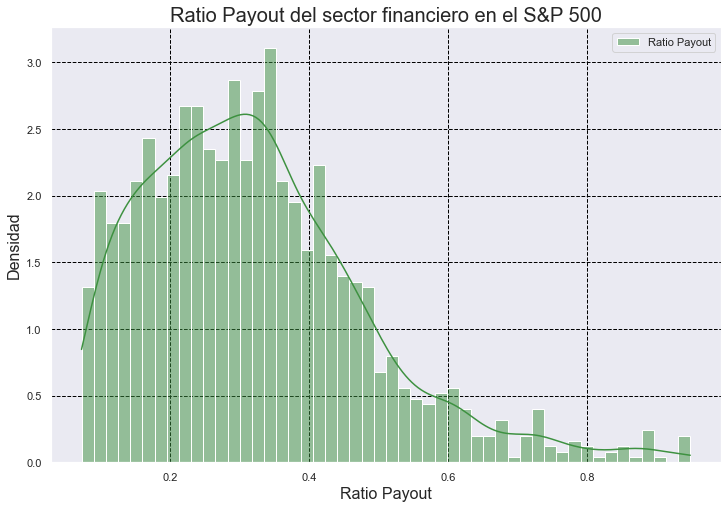

In [27]:
#Estética seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("darkgrid", {"grid.color": "black", "grid.linestyle": "--"})
sns.set_context(rc={"grid.linewidth": 1})
colors = ["#3D9140", "#4374B3"]
sns.set_palette(sns.color_palette(colors))


#Gráfico
sns.histplot(data=data_RatioPayout, stat='density', kde=True, kde_kws={'bw_method': 0.1},
             bins=50, log_scale=False, shrink=1)

#Estética matplot
plt.title('Ratio Payout del sector financiero en el S&P 500', fontsize=20)
plt.xlabel('Ratio Payout', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

In [30]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=2).fit(data_RatioPayout)
kde.score_samples(data_RatioPayout)

array([-1.61847394, -1.6162567 , -1.61561145, ..., -1.61537224,
       -1.61531609, -1.61848648])

In [ ]:
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs) #entrena el anterior objeto kde
    return kde.evaluate(x_grid) #para evaluarlo posteriormente.
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, 
                          bw='cv_ml',  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis]) #Introducimos un vector de dos dimensiones
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf) #Regresa el vector de la función estimada.


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

print( "Package Versions:")
import sklearn; print( "  scikit-learn:", sklearn.__version__)
import scipy; print ("  scipy:", scipy.__version__)
import statsmodels; print( "  statsmodels:", statsmodels.__version__)